In [1]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

C:\Users\pj903\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

## Product

In [2]:
product = pd.read_csv('product.csv', dtype={"CLNT_ID":np.str, "SESS_ID":np.str},thousands=","
                     ,usecols = [0,1,2,3,5,6,7])
product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,07605037,12,642112,[바비브라운],39000,1
1,4140076,10189797,13,570603,데상트,39000,2
2,4142395,06158159,85,179538,[아베다],39000,1
3,4144914,07935714,12,554336,아디다스 키즈,39000,1
4,4144917,06406509,78,190306,데코르테,39000,5


## Customer

In [3]:
custom = pd.read_csv('custom.csv', dtype={"CLNT_ID":np.str})
custom.head()

,CLNT_ID,CLNT_GENDER,CLNT_AGE
0,4830726,F,30
1,4830874,F,40
2,4830975,F,30
3,4831275,F,30
4,4825325,F,30


## Session

In [4]:
session = pd.read_csv('new_session.csv', dtype={"CLNT_ID":np.str, "SESS_ID":np.str},thousands=",",
                     usecols=[0,1,3,4,5,6,7])
session.head()

,CLNT_ID,SESS_ID,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM
0,5873599,08641867,20180509,82.0,1890.0,mobile,Daejeon
1,5873599,06616320,20180611,105.0,1604.0,mobile,Busan
2,5873599,05886172,20180624,41.0,632.0,mobile,Daejeon
3,5873884,01050889,20180913,160.0,1035.0,mobile,Gyeonggi-do
4,5874461,10298270,20180412,13.0,298.0,mobile,Seoul


In [5]:
# month columns
session['SESS_DT'] = pd.to_datetime(session['SESS_DT'], format="%Y%m%d")
session['SESS_month'] = pd.DatetimeIndex(session['SESS_DT']).month

## Master

In [6]:
master = pd.read_csv('new_Master.csv',
                     usecols=[0,5])
master.head()

,PD_C,CLAC0_NM
0,64382,스포츠/레저
1,62282,패션의류
2,61729,유아동
3,61537,패션의류
4,58820,패션의류


In [7]:
labels, uniques = pd.factorize(master['CLAC0_NM'],sort=True)
print(uniques)

Index(['가구/침구/인테리어', '가전/디지털', '반려동물', '스포츠/레저', '식품', '여행/서비스/금융', '유아동',
       '주방/생활/건강', '패션의류', '화장품/뷰티'],
      dtype='object')


# Merge datasets

In [8]:
m0 = pd.merge(product, custom, on='CLNT_ID', how = 'inner')
m00 = pd.merge(m0, master, on=['PD_C'], how = 'inner')
m1 = pd.merge(m00, session, on=['CLNT_ID','SESS_ID'], how = 'inner')
m0.shape,m00.shape,m1.shape

((3988587, 9), (3988587, 10), (3988587, 16))

In [9]:
m1.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLNT_GENDER,CLNT_AGE,CLAC0_NM,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,SESS_month
0,4140076,10189797,13,570603,데상트,39000,2,F,40,스포츠/레저,2018-04-13,18.0,113.0,mobile,Gyeonggi-do,4
1,4140076,10189797,13,411029,아디다스(의류),29000,1,F,40,스포츠/레저,2018-04-13,18.0,113.0,mobile,Gyeonggi-do,4
2,4148106,06537318,21,570603,데상트,39000,1,F,30,스포츠/레저,2018-06-13,20.0,144.0,mobile,Gwangju,6
3,4148106,06662803,94,570603,데상트,39000,1,F,30,스포츠/레저,2018-06-11,93.0,1371.0,mobile,Seoul,6
4,4148106,06662803,94,529438,라코스테(의류),88000,1,F,30,패션의류,2018-06-11,93.0,1371.0,mobile,Seoul,6


In [10]:
#'가구/침구/인테리어', '가전/디지털', '반려동물', '스포츠/레저', '식품', '여행/서비스/금융', '유아동', 
# '주방/생활/건강', '패션의류', '화장품/뷰티'
class1=m1.loc[m1['CLAC0_NM']=='가구/침구/인테리어']
class2=m1.loc[m1['CLAC0_NM']=='가전/디지털']
class3=m1.loc[m1['CLAC0_NM']=='반려동물']
class4=m1.loc[m1['CLAC0_NM']=='스포츠/레저']
class5=m1.loc[m1['CLAC0_NM']=='식품']
class6=m1.loc[m1['CLAC0_NM']=='여행/서비스/금융']
class7=m1.loc[m1['CLAC0_NM']=='유아동']
class8=m1.loc[m1['CLAC0_NM']=='주방/생활/건강']
class9=m1.loc[m1['CLAC0_NM']=='패션의류']
class10=m1.loc[m1['CLAC0_NM']=='화장품/뷰티']

In [11]:
#Class1
p1=class1['PD_BUY_CT'].groupby(class1['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class1['HITS_SEQ'].groupby(class1['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class1['TOT_SESS_HR_V'].groupby(class1['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class1['CLNT_AGE'].groupby(class1['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class1=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class1.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [12]:
#Class2
p1=class2['PD_BUY_CT'].groupby(class2['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class2['HITS_SEQ'].groupby(class2['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class2['TOT_SESS_HR_V'].groupby(class2['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class2['CLNT_AGE'].groupby(class2['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class2=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class2.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [13]:
#Class3
p1=class3['PD_BUY_CT'].groupby(class3['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class3['HITS_SEQ'].groupby(class3['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class3['TOT_SESS_HR_V'].groupby(class3['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class3['CLNT_AGE'].groupby(class3['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class3=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class3.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [14]:
#Class4
p1=class4['PD_BUY_CT'].groupby(class4['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class4['HITS_SEQ'].groupby(class4['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class4['TOT_SESS_HR_V'].groupby(class4['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class4['CLNT_AGE'].groupby(class4['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class4=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class4.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [15]:
#Class5
p1=class5['PD_BUY_CT'].groupby(class5['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class5['HITS_SEQ'].groupby(class5['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class5['TOT_SESS_HR_V'].groupby(class5['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class5['CLNT_AGE'].groupby(class5['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class5=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class5.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [16]:
#Class6
p1=class6['PD_BUY_CT'].groupby(class6['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class6['HITS_SEQ'].groupby(class6['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class6['TOT_SESS_HR_V'].groupby(class6['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class6['CLNT_AGE'].groupby(class6['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class6=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class6.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [17]:
#Class7
p1=class7['PD_BUY_CT'].groupby(class7['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class7['HITS_SEQ'].groupby(class7['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class7['TOT_SESS_HR_V'].groupby(class7['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class7['CLNT_AGE'].groupby(class7['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class7=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class7.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [18]:
#Class8
p1=class8['PD_BUY_CT'].groupby(class8['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class8['HITS_SEQ'].groupby(class8['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class8['TOT_SESS_HR_V'].groupby(class8['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class8['CLNT_AGE'].groupby(class8['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class8=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class8.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [19]:
#Class9
p1=class9['PD_BUY_CT'].groupby(class9['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class9['HITS_SEQ'].groupby(class9['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class9['TOT_SESS_HR_V'].groupby(class9['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class9['CLNT_AGE'].groupby(class9['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class9=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class9.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [20]:
#Class10
p1=class10['PD_BUY_CT'].groupby(class10['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class10['HITS_SEQ'].groupby(class10['SESS_DT']).agg({'HITS_SEQ_sum': np.sum})
p3=class10['TOT_SESS_HR_V'].groupby(class10['SESS_DT']).agg({'TOT_SESS_HR_V_sum':np.sum})
p4=class10['CLNT_AGE'].groupby(class10['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class10=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class10.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

# <Class1 : 가구/침구/인테리어>

In [21]:
Class1.head()

,BUY_CT_sum,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean
SESS_DT,,,,
2018-04-01,1306,66018,1506274.0,35.022676
2018-04-02,2280,52489,1361359.0,34.607465
2018-04-03,1615,55396,1325181.0,34.291188
2018-04-04,2079,38096,976517.0,34.294574
2018-04-05,4097,38952,971935.0,34.150943


In [51]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    diff.append(dataset[0])
    for i in arange(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
    return pd.Series(diff)

In [64]:
# inverse_difference
def inverse_difference(diff, interval=1):
    origin = list()
    origin.append(diff[0])
    for i in arange(interval, len(diff)):
            value = diff[i] + origin[i - interval]
            origin.append(value)
    return pd.Series(origin)

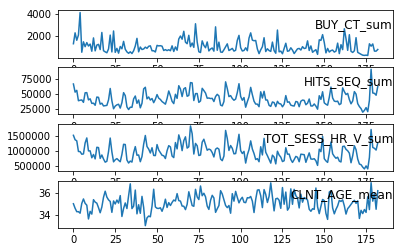

In [23]:
#Plot of all variables
values = Class1.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(Class1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

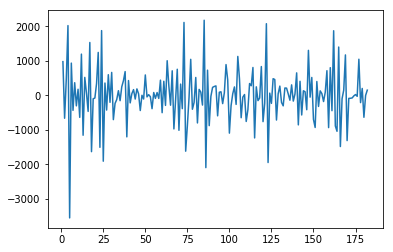

In [47]:
#with diff
Y = Class1['BUY_CT_sum']
diff = difference(Y)[1:]
pyplot.plot(diff)
pyplot.show()

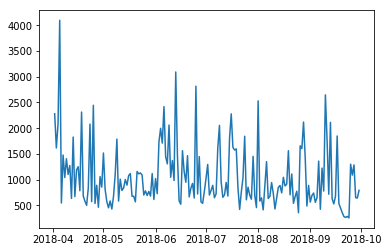

In [49]:
#without diff
pyplot.plot(Y[1:])
pyplot.show()

In [56]:
diff=difference(Y)
diff.index=Class1.index
pd.concat([Class1,diff],axis=1)

,BUY_CT_sum,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean,0
SESS_DT,,,,,
2018-04-01,1306,66018,1506274.0,35.022676,1306
2018-04-02,2280,52489,1361359.0,34.607465,974
2018-04-03,1615,55396,1325181.0,34.291188,-665
2018-04-04,2079,38096,976517.0,34.294574,464
2018-04-05,4097,38952,971935.0,34.150943,2018
2018-04-06,546,39400,885808.0,35.050302,-3551
2018-04-07,1478,35398,895315.0,35.465347,932
2018-04-08,1042,51322,1255281.0,35.061920,-436
2018-04-09,1406,51639,1420113.0,34.890323,364


In [26]:
#make dataset 'df1' with diff
diff.index=Class1.index[1:]
df1=pd.concat([Class1,diff],axis=1)[1:]

In [27]:
df1.rename(columns={0: 'diff_Y'}, inplace=True)
#remove original Y
df1=df1[['HITS_SEQ_sum', 'TOT_SESS_HR_V_sum', 'CLNT_AGE_mean','diff_Y']]
df1.head()

,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-02,52489,1361359.0,34.607465,974.0
2018-04-03,55396,1325181.0,34.291188,-665.0
2018-04-04,38096,976517.0,34.294574,464.0
2018-04-05,38952,971935.0,34.150943,2018.0
2018-04-06,39400,885808.0,35.050302,-3551.0


## Scale & prepare dataset for modeling

In [28]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm
scaled_df1=minmax(df1)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-02,0.467709,0.679355,0.404708,0.790531
2018-04-03,0.508258,0.653711,0.324854,0.504193
2018-04-04,0.266947,0.406567,0.325709,0.701433
2018-04-05,0.278887,0.403319,0.289445,0.972921
2018-04-06,0.285136,0.342269,0.516516,0.000000


In [29]:
def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm
inverse_minmax(scaled_df1,df1).head()

,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-02,52489.0,1361359.0,34.607465,974.0
2018-04-03,55396.0,1325181.0,34.291188,-665.0
2018-04-04,38096.0,976517.0,34.294574,464.0
2018-04-05,38952.0,971935.0,34.150943,2018.0
2018-04-06,39400.0,885808.0,35.050302,-3551.0


# Modeling

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# With the Original

In [30]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [33]:
dataset=Class1
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.273366   0.656419   0.782075   0.509540  0.526946
2   0.526946   0.467709   0.679355   0.404708  0.353814
3   0.353814   0.508258   0.653711   0.324854  0.474616
4   0.474616   0.266947   0.406567   0.325709  1.000000
5   1.000000   0.278887   0.403319   0.289445  0.075501


In [34]:
# split into train and test sets
values = reframed.values
n_train = int(len(Class1)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(128, 1, 4) (128,) (54, 1, 4) (54,)


Train on 128 samples, validate on 54 samples
Epoch 1/50
 - 1s - loss: 0.2037 - val_loss: 0.1428
Epoch 2/50
 - 0s - loss: 0.1906 - val_loss: 0.1324
Epoch 3/50
 - 0s - loss: 0.1771 - val_loss: 0.1217
Epoch 4/50
 - 0s - loss: 0.1633 - val_loss: 0.1126
Epoch 5/50
 - 0s - loss: 0.1504 - val_loss: 0.1040
Epoch 6/50
 - 0s - loss: 0.1399 - val_loss: 0.0978
Epoch 7/50
 - 0s - loss: 0.1308 - val_loss: 0.0939
Epoch 8/50
 - 0s - loss: 0.1241 - val_loss: 0.0913
Epoch 9/50
 - 0s - loss: 0.1191 - val_loss: 0.0904
Epoch 10/50
 - 0s - loss: 0.1155 - val_loss: 0.0902
Epoch 11/50
 - 0s - loss: 0.1135 - val_loss: 0.0913
Epoch 12/50
 - 0s - loss: 0.1122 - val_loss: 0.0928
Epoch 13/50
 - 0s - loss: 0.1117 - val_loss: 0.0949
Epoch 14/50
 - 0s - loss: 0.1117 - val_loss: 0.0968
Epoch 15/50
 - 0s - loss: 0.1121 - val_loss: 0.0981
Epoch 16/50
 - 0s - loss: 0.1124 - val_loss: 0.0988
Epoch 17/50
 - 0s - loss: 0.1126 - val_loss: 0.0991
Epoch 18/50
 - 0s - loss: 0.1126 - val_loss: 0.0991
Epoch 19/50
 - 0s - loss: 0.

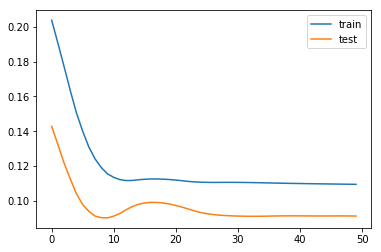

In [35]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 477.419


# With the Diff

In [103]:
df1.tail()

,HITS_SEQ_sum,TOT_SESS_HR_V_sum,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-09-26,90650,1696711.0,36.965241,-212.0
2018-09-27,51043,1108431.0,35.261383,198.0
2018-09-28,50443,1080186.0,36.036697,-637.0
2018-09-29,47322,1021967.0,34.516129,-6.0
2018-09-30,61864,1262390.0,36.226138,149.0


In [188]:
dataset=df1
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.467709   0.679355   0.404708   0.790531  0.508258
2   0.508258   0.653711   0.324854   0.504193  0.266947
3   0.266947   0.406567   0.325709   0.701433  0.278887
4   0.278887   0.403319   0.289445   0.972921  0.285136
5   0.285136   0.342269   0.516515   0.000000  0.229314


In [189]:
# split into train and test sets
values = reframed.values
n_train = int(len(df1)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(127, 1, 4) (127,) (54, 1, 4) (54,)


Train on 127 samples, validate on 54 samples
Epoch 1/50
 - 3s - loss: 0.1271 - val_loss: 0.1058
Epoch 2/50
 - 0s - loss: 0.1176 - val_loss: 0.0977
Epoch 3/50
 - 0s - loss: 0.1080 - val_loss: 0.0900
Epoch 4/50
 - 0s - loss: 0.0988 - val_loss: 0.0829
Epoch 5/50
 - 0s - loss: 0.0903 - val_loss: 0.0762
Epoch 6/50
 - 0s - loss: 0.0822 - val_loss: 0.0700
Epoch 7/50
 - 0s - loss: 0.0747 - val_loss: 0.0642
Epoch 8/50
 - 0s - loss: 0.0677 - val_loss: 0.0589
Epoch 9/50
 - 0s - loss: 0.0612 - val_loss: 0.0540
Epoch 10/50
 - 0s - loss: 0.0552 - val_loss: 0.0495
Epoch 11/50
 - 0s - loss: 0.0497 - val_loss: 0.0455
Epoch 12/50
 - 0s - loss: 0.0447 - val_loss: 0.0419
Epoch 13/50
 - 0s - loss: 0.0401 - val_loss: 0.0387
Epoch 14/50
 - 0s - loss: 0.0360 - val_loss: 0.0359
Epoch 15/50
 - 0s - loss: 0.0324 - val_loss: 0.0335
Epoch 16/50
 - 0s - loss: 0.0292 - val_loss: 0.0314
Epoch 17/50
 - 0s - loss: 0.0264 - val_loss: 0.0297
Epoch 18/50
 - 0s - loss: 0.0241 - val_loss: 0.0284
Epoch 19/50
 - 0s - loss: 0.

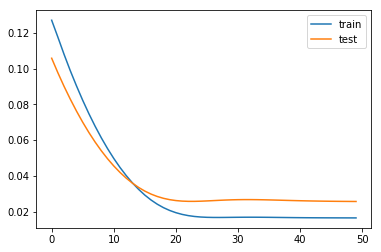

In [190]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [143]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
dfhat = concatenate((yhat, test_X[:, 0:3]), axis=1)
inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inv_dfhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
df = concatenate((test_y, test_X[:, 0:3]), axis=1)
inv_df = scaler.inverse_transform(df)
inv_y = inv_df[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11689.356


#### 다른 코드인데 에러..

In [149]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

In [150]:
#split data
#train=minmax(df1[:145])
#test=minmax(df1[145:])
train=df1[:145]
test=df1[145:]

In [153]:
# transform train
train = train.values.reshape(train.shape[0], train.shape[1])
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled =  scaler.fit(train).transform(train)
X, y = train[:,0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
neurons=1
batch_size=1
nb_epoch=500
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
model

In [158]:
repeats=10
error_scores = list()
for r in arange(repeats):
    # fit the base model
    lstm_model = model
    # forecast test dataset
    predictions = list()
    for i in arange(len(test)):
        # predict
        X, y = test.values[i,0:-1], test.values[i, -1]
        X = X.reshape(1, 1, len(X))
        yhat = lstm_model.predict(X, batch_size=batch_size)
        yhat=yhat[0,0]
        # fit scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        # transform test
        test = test.values.reshape(test.shape[0], test.shape[1])
        test_scaled =  scaler.fit(test).transform(test)
        # invert scaling
        yhat=inverse_minmax(test_scaled,test)
        # invert differencing
        yhat = yhat+df1.values[:,145+i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(df1.values[-37:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
    print(error_scores)

IndexError: index 145 is out of bounds for axis 1 with size 4